# SC2001 Lab Project 2: Djikstra's Algorithm

In [2]:
# Relevant imports for the project
import numpy as np
import pandas as pd
import math
import random
from random import randint
import matplotlib.pyplot as plt
import time
import heapq
import networkx as nx
np.random.seed(19)

## (a) Suppose the input graph G = (V, E) is stored in an adjacency matrix and we use an array for the priority queue. Implement the Dijkstra’s algorithm using this setting and analyze its time complexity with respect to |V| and |E| both theoretically and empirically.

### Theoretical Analysis

O(|V|²) + O(|E| × (k + |V|))

### Empirical Analysis

For this question, let's first define a few key data structures: 
- Graph (We will make also hold adjacency list for use in future questions
- Priority Queue implemented with an array

In [3]:
class Graph:
    def __init__(self, num_nodes, num_edges):
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.adj_matrix = None
        self.adj_list = None
        
        # Check if the graph is valid
        if num_nodes * (num_nodes - 1) < num_edges:
            print(f"Impossible to generate a simple graph with {num_nodes} nodes and {num_edges} edges!")
            return None
        
        # Generate the graph
        self._generate_graph()
    
    def _generate_graph(self):
        # Generate a random directed graph with both representations. Creates a cycle to ensure connectivity.
        
        # Initialize adjacency list
        self.adj_list = [[] for _ in range(self.num_nodes)]
        existing_edges = set()
        
        # Create a simple cycle for connectivity
        for i in range(self.num_nodes):
            u = i
            v = (i + 1) % self.num_nodes  # Wrap around to form a cycle
            w = random.randint(1, 20)
            self.adj_list[u].append([v, w])
            existing_edges.add((u, v))
        
        # Add remaining random edges
        remaining_edges = self.num_edges - self.num_nodes
        while remaining_edges > 0:
            start_node = random.randint(0, self.num_nodes - 1)
            end_node = random.randint(0, self.num_nodes - 1)
            weight = random.randint(1, 20)
            
            if start_node != end_node and (start_node, end_node) not in existing_edges:
                self.adj_list[start_node].append([end_node, weight])
                existing_edges.add((start_node, end_node))
                remaining_edges -= 1
        
        # Create adjacency matrix from adjacency list
        self.adj_matrix = np.zeros((self.num_nodes, self.num_nodes), dtype=int)
        for i in range(self.num_nodes):
            for neighbor in self.adj_list[i]:
                node = neighbor[0]
                weight = neighbor[1]
                self.adj_matrix[i][node] = weight
    
    def get_matrix(self):
        return self.adj_matrix
    
    def get_list(self):
        return self.adj_list
    
    def print_graph(self):
        print("Adjacency Matrix:")
        print(self.adj_matrix)
        
        print("\nAdjacency List:")
        for i in range(self.num_nodes):
            print(f"from node {i:02d}: {self.adj_list[i]}")
    
    def visualize(self):
        G = nx.DiGraph()
        for i in range(self.num_nodes):
            G.add_node(i)
        
        for i in range(self.num_nodes):
            for neighbor in self.adj_list[i]:
                G.add_edge(i, neighbor[0], weight=neighbor[1])
        
        try:
            pos = nx.planar_layout(G)
            nx.draw(G, pos, with_labels=True)
        except nx.NetworkXException:
            print("\nGraph is not planar, using alternative representation")
            pos = nx.spring_layout(G)
            nx.draw(G, pos, with_labels=True)
        
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
        plt.show()

In [4]:
class PriorityQueueArray:
    
    def __init__(self):
        self.queue = []
    
    def is_empty(self):
        return len(self.queue) == 0
    
    def insert(self, priority, value):
        self.queue.append([priority, value])
    
    def extract_min(self):
        if self.is_empty():
            raise IndexError("Priority queue is empty")
            
        min_idx = 0
        min_priority = self.queue[0][0]
        
        # Find the element with minimum priority value
        for i in range(1, len(self.queue)):
            if self.queue[i][0] < min_priority:
                min_priority = self.queue[i][0]
                min_idx = i
        
        # Remove and return the minimum element
        min_element = self.queue.pop(min_idx)
        return min_element[1]
    
    def remove(self, value):
        for i in range(len(self.queue)):
            if self.queue[i][1] == value:
                del self.queue[i]
                return True
        return False

Now that we have made our fundamental data structures, lets do our implementation of Djikstra's algorithm with an array priority queue.

In [5]:
def dijkstra_adj_matrix_array(g, source):  
    n = len(g)
    d = [math.inf for _ in range(n)]
    pi = [None for _ in range(n)]  
    S = [0 for _ in range(n)]    
    
    d[source] = 0
    
    # Initialize priority queue with all vertices
    pq = PriorityQueueArray()
    for v in range(n):
        pq.insert(d[v], v)
    
    while not pq.is_empty():
        # Extract vertex with minimum distance estimate
        u = pq.extract_min()
        S[u] = 1 
        
        # For all vertices adjacent to u and not in S
        for v in range(n):
            if g[u][v] > 0:  # If there's an edge from u to v
                if S[v] != 1 and d[v] > d[u] + g[u][v]:
                    # Remove v from queue
                    pq.remove(v)
                    
                    # Update distance and predecessor
                    d[v] = d[u] + g[u][v]
                    pi[v] = u
                    
                    # Insert v into queue with new priority
                    pq.insert(d[v], v)
    
    return d, pi

Now let's run some experiments!

In [6]:
# Create graphs function
def make_graph(num_nodes, num_edges):
    if num_nodes * (num_nodes - 1) < num_edges:
        print(f"Impossible to generate a simple graph with {num_nodes} nodes and {num_edges} edges!")
        return None, None

    # Create adjacency list representation
    g2 = [[] for _ in range(num_nodes)]
    existing_edges = set()
    
    # Create simple cycle to guarantee strong connectivity
    for i in range(num_nodes):
        u = i
        v = (i + 1) % num_nodes  # Wrap around to form a cycle
        w = randint(1, 20)
        g2[u].append([v, w])
        existing_edges.add((u, v))
    
    remaining_edges = num_edges - num_nodes

    while remaining_edges > 0: 
        start_node = randint(0, num_nodes - 1)
        end_node = randint(0, num_nodes - 1)
        weight = randint(1, 20)
        
        if start_node != end_node and (start_node, end_node) not in existing_edges:
            g2[start_node].append([end_node, weight])
            existing_edges.add((start_node, end_node))
            remaining_edges -= 1
                
    # Create adjacency matrix from list
    g1 = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(len(g2)):
        for neighbor in g2[i]:
            node = neighbor[0]
            weight = neighbor[1]
            g1[i][node] = weight
            
    return g1, g2

Now, let's make our experiment for vertices 

Running experiment with varying number of vertices...
Completed 50 vertices, average time: 0.000477 seconds
Completed 100 vertices, average time: 0.001498 seconds
Completed 150 vertices, average time: 0.003147 seconds
Completed 200 vertices, average time: 0.005431 seconds
Completed 250 vertices, average time: 0.009143 seconds
Completed 300 vertices, average time: 0.012885 seconds
Completed 350 vertices, average time: 0.016451 seconds
Completed 400 vertices, average time: 0.021617 seconds
Completed 450 vertices, average time: 0.027349 seconds
Completed 500 vertices, average time: 0.034250 seconds
Completed 550 vertices, average time: 0.041469 seconds


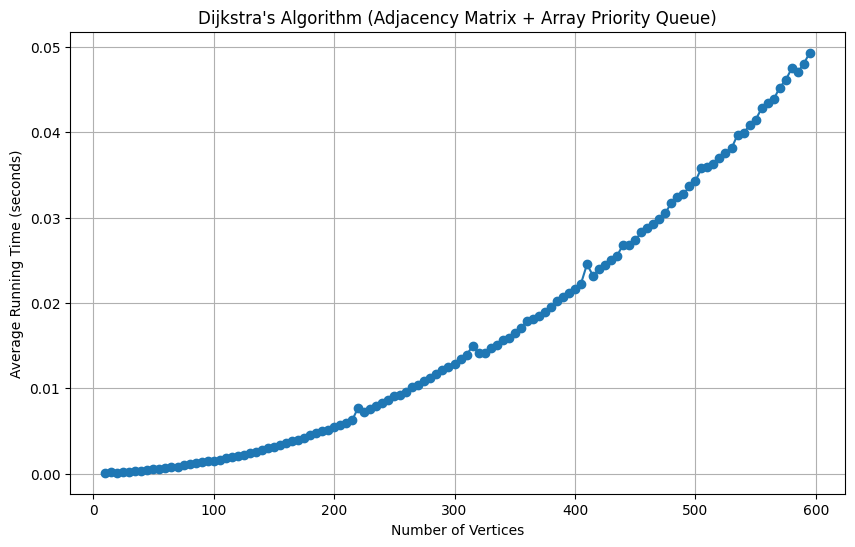

In [7]:
def run_vertex_experiment():
    print("Running experiment with varying number of vertices...")
    
    # Parameters matching friend's setup
    n_vertices = range(10, 600, 5)  # From 10 to 600 with step 5
    n_repetitions = 10
    running_times = []
    
    for n in n_vertices:
        # 3*n edges for each graph
        m = min(n * (n - 1), 3 * n)
        g1, g2 = make_graph(n, m)
        
        if g1 is None:
            running_times.append(None)
            continue
            
        start_time = time.time()
        for _ in range(n_repetitions):
            source = randint(0, n - 1)  # Random source for each repetition
            d, pi = dijkstra_adj_matrix_array(g1, source)
        avg_time = (time.time() - start_time) / n_repetitions
        running_times.append(avg_time)
        
        # Print progress update
        if n % 50 == 0:
            print(f"Completed {n} vertices, average time: {avg_time:.6f} seconds")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(n_vertices, running_times, 'o-')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Average Running Time (seconds)')
    plt.title('Dijkstra\'s Algorithm (Adjacency Matrix + Array Priority Queue)')
    plt.grid(True)
    plt.savefig('dijkstra_vertex_experiment.png')
    plt.show()
    
    return n_vertices, running_times

n_vertices, v_running_times = run_vertex_experiment()

Now, let's run our experiments for the number of edges

Running experiment with varying number of edges (fixed at 600 vertices)...
Completed 600 edges, average time: 0.050358 seconds
Completed 720 edges, average time: 0.049370 seconds
Completed 864 edges, average time: 0.048537 seconds
Completed 1036 edges, average time: 0.049170 seconds
Completed 1244 edges, average time: 0.049296 seconds
Completed 1492 edges, average time: 0.050605 seconds
Completed 1791 edges, average time: 0.049858 seconds
Completed 2149 edges, average time: 0.051098 seconds
Completed 2579 edges, average time: 0.050808 seconds
Completed 3095 edges, average time: 0.051130 seconds
Completed 3715 edges, average time: 0.051197 seconds
Completed 4458 edges, average time: 0.052459 seconds
Completed 5349 edges, average time: 0.051961 seconds
Completed 6419 edges, average time: 0.052745 seconds
Completed 7703 edges, average time: 0.054194 seconds
Completed 9244 edges, average time: 0.054278 seconds
Completed 11093 edges, average time: 0.054788 seconds
Completed 13311 edges, ave

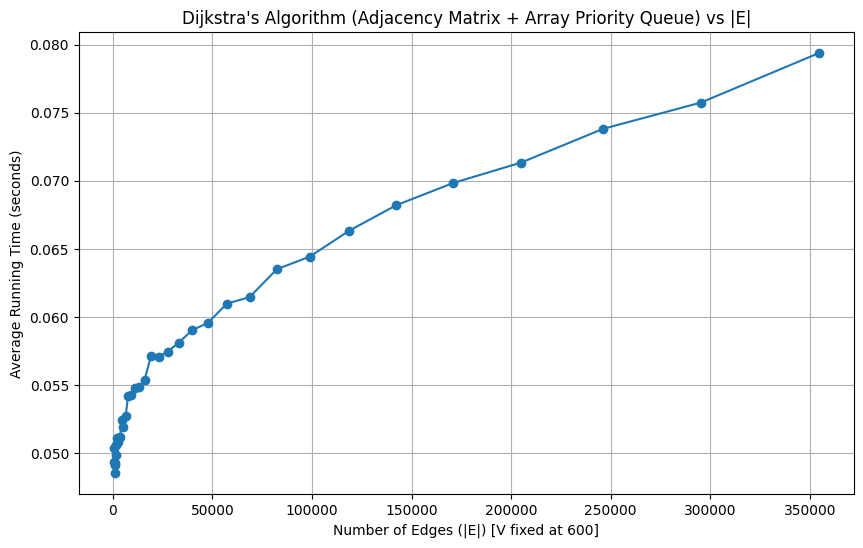

In [45]:
# Experiment 2: Varying number of edges with fixed vertices
def run_edge_experiment(n=500):
    print(f"Running experiment with varying number of edges (fixed at {n} vertices)...")
    
    max_edges = n * (n - 1)  # Maximum possible edges for a directed graph

    # Generate edge counts with exponential growth (like friend's code)
    edge_list = []
    e = n  # Start with n edges (1 per vertex on average)
    while e <= max_edges:
        edge_list.append(int(e))
        e *= 1.2  # Increase by 20% each step
    
    n_repetitions = 5
    running_times = []
    edge_counts = []
    
    for m in edge_list:
        g1, g2 = make_graph(n, m)
        
        if g1 is None:
            continue
            
        start_time = time.time()
        for _ in range(n_repetitions):
            source = randint(0, n - 1)  # Random source
            d, pi = dijkstra_adj_matrix_array(g1, source)
        avg_time = (time.time() - start_time) / n_repetitions
        
        running_times.append(avg_time)
        edge_counts.append(m)
        
        # Print progress
        print(f"Completed {m} edges, average time: {avg_time:.6f} seconds")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(edge_counts, running_times, 'o-')
    plt.xlabel(f'Number of Edges (|E|) [V fixed at {n}]')
    plt.ylabel('Average Running Time (seconds)')
    plt.title('Dijkstra\'s Algorithm (Adjacency Matrix + Array Priority Queue) vs |E|')
    plt.grid(True)
    plt.savefig('dijkstra_edge_experiment.png')
    plt.show()
    
    return edge_counts, running_times


edge_counts, e_running_times = run_edge_experiment(600)

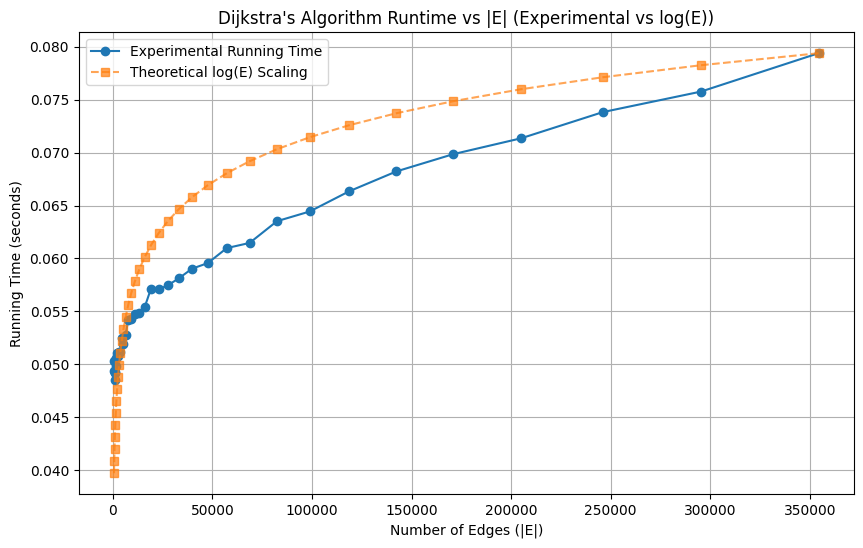

In [50]:
# Convert lists to NumPy arrays if they are not already
edge_counts = np.array(edge_counts)
e_running_times = np.array(e_running_times)

# Compute log(E) values
log_E = np.log(edge_counts)
log_E_scaled = log_E / np.max(log_E) * np.max(e_running_times)

# Normalizing running time against log(E)
normalized_time_logE = e_running_times / log_E

# Plot experimental vs theoretical log(E) scaling
plt.figure(figsize=(10, 6))
plt.plot(edge_counts, e_running_times, 'o-', label="Experimental Running Time")
plt.plot(edge_counts, log_E_scaled, 's--', label="Theoretical log(E) Scaling", alpha=0.7)
plt.xlabel('Number of Edges (|E|)')
plt.ylabel('Running Time (seconds)')
plt.title("Dijkstra's Algorithm Runtime vs |E| (Experimental vs log(E))")
plt.legend()
plt.grid(True)
plt.show()

Well, above is unexpected. While we thought it would be independent of |E|, it seems to follow an $\mathcal{O}(\log(n))$

This can be explained by the overhead of memory accesses when a better path is found. When a better path is found, the remove method removes the value in the priority queue at $\mathcal{O}(|V|)$ time, which is roughly constant when |V| is constant in the above experiment. Let's denote this constant value by C.

When the graph is sparse, the probability that d[v] < d[u] + W(u,v) is low due the low number of candidates. However, as $|E|$ increases, there are more candidate edges that offer a better solution, resulting in the remove operation being used. <br>

Let T(n) denote the time taken to replace an edge (p,q) in the priority queue for fixed |V| and no. of edges n
<br>

Then, $T(n+1) = T(n) + \left(\frac{1}{\frac{n}{|V|}+1}\right)C$, where C = time taken to replace the edge in the priority queue


$$
T(n+1) = T(n) + \frac{|V|}{n + |V|} C
$$

Expanding recursively:

$$
T(n) = T(n-1) + \frac{|V|}{n-1+|V|} C
$$

$$
= T(n-1) + \frac{|V|}{n-1+|V|} C
$$

$$
= T(n-2) + \frac{|V|}{n-2+|V|} C + \frac{|V|}{n-1+|V|} C
$$

$$
= T(n-k) + \sum_{i=1}^{k} \frac{|V|}{n-i+|V|} C
$$

Since \( n - k = |V| - 1 \), we get \( k = n - |V| + 1 \), thus:

$$
T(n) = T(|V|-1) + \sum_{i=1}^{n-|V|+1} \frac{|V|}{n+|V|-i} C
$$

$$
= T(|V|-1) + \left( \sum_{i=1}^{n-|V|+1} \frac{|V|}{n+|V|-i} \right) C
$$
When we set $j=n+|V|−i,$<br>
<br>
When $i=1,$  $j = n+|V|-1,$<br>
When $i = n−|V|+1,$  $j= n+|V|−(n−|V|+1) = 2|V|−1,$
$$
\therefore T(n) = T(|V|-1) + \left( \sum_{j=2|V|-1}^{n+|V|-1} \frac{|V|}{j} \right) C
$$

$$
= C\cdot|V|\cdot(\ln(|E|+|V|−1)−\ln(2|V|−1)) + A
$$

$$
= \mathcal{O}(|V|\log(|E|))
$$
And above matches our empirical results

## (b) Suppose the input graph G = (V, E) is stored in an array of adjacency lists and we use a minimizing heap for the priority queue. Implement the Dijkstra’s algorithm using this setting and analyze its time complexity with respect to |V| and |E| both theoretically and empirically. 

### Theoretical Analysis

TODO: Add this in - Ali
$$
\mathcal{O}((|V| + |E|)\log{(|V|)})
$$

$$
 O(|V| log |V| + |E|(k + log |V|))
$$
k = time taken for updating the queue when a better path is found

### Empirical Analysis

Luckily for us, there already exists a library called heapq, that we can use to make our heap queue data structure. All we need to do is define our new djikstra algorithm and run some experiments

In [42]:
def dijkstra_adj_list_heap(adj_list, source):
    n = len(adj_list)
    
    # Initialize data structures
    d = [float('inf') for _ in range(n)]   # Distance array
    pi = [None for _ in range(n)]          # Predecessor array
    S = [0 for _ in range(n)]              # Set of visited nodes (in S)
    
    d[source] = 0
    pq = [(0, source)]  # Priority queue for (distance, vertex)
    
    # In the heap, we track the vertices that are still active
    in_heap = set([source])
    
    while pq:
        # Extract the vertex with minimum distance
        dist_u, u = heapq.heappop(pq)
        in_heap.remove(u)
        
        if S[u] == 1 or dist_u > d[u]:
            continue
        
        # Add u to S
        S[u] = 1
        
        # Relax all edges from u
        for v, weight in adj_list[u]:
            # If v is not in S and we found a shorter path
            if S[v] != 1 and d[v] > d[u] + weight:
                # Update distance and predecessor
                d[v] = d[u] + weight
                pi[v] = u
                
                # Only add v to the heap if it's not already in it
                if v not in in_heap:
                    heapq.heappush(pq, (d[v], v))
                    in_heap.add(v)
    
    return d, pi

Now let's run some experiments

Running experiment with varying number of vertices (adj list + heap)...
Completed 100 vertices, average time: 0.000049 seconds
Completed 600 vertices, average time: 0.000364 seconds
Completed 1100 vertices, average time: 0.000633 seconds
Completed 1600 vertices, average time: 0.001100 seconds
Completed 2100 vertices, average time: 0.001698 seconds
Completed 2600 vertices, average time: 0.001851 seconds
Completed 3100 vertices, average time: 0.001944 seconds
Completed 3600 vertices, average time: 0.002209 seconds
Completed 4100 vertices, average time: 0.003210 seconds
Completed 4600 vertices, average time: 0.003161 seconds
Completed 5100 vertices, average time: 0.003875 seconds
Completed 5600 vertices, average time: 0.004143 seconds
Completed 6100 vertices, average time: 0.004178 seconds
Completed 6600 vertices, average time: 0.005103 seconds
Completed 7100 vertices, average time: 0.004663 seconds
Completed 7600 vertices, average time: 0.005230 seconds
Completed 8100 vertices, average t

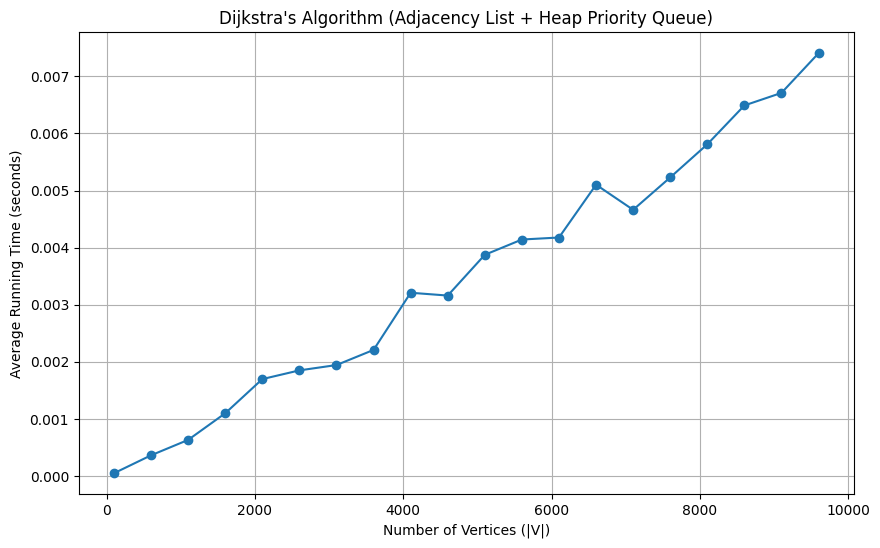

(range(100, 10001, 500),
 [4.9448013305664064e-05,
  0.0003635883331298828,
  0.0006334304809570313,
  0.0010998249053955078,
  0.0016982078552246094,
  0.0018508434295654297,
  0.0019442081451416016,
  0.0022092342376708986,
  0.0032104015350341796,
  0.003161001205444336,
  0.0038750171661376953,
  0.004142570495605469,
  0.00417780876159668,
  0.005103015899658203,
  0.0046631813049316405,
  0.005230045318603516,
  0.005810213088989258,
  0.006490850448608398,
  0.006710624694824219,
  0.007405567169189453])

In [43]:
def run_heap_vertex_experiment():
    print("Running experiment with varying number of vertices (adj list + heap)...")
    
    # Parameters
    n_vertices = range(100, 10001, 500) 
    n_repetitions = 5
    running_times = []
    
    for n in n_vertices:
        # Create a sparse graph (avg degree = 3)
        m = min(n * (n - 1), 3 * n)
        _, g2 = make_graph(n, m)  # g2 is the adjacency list
        
        if g2 is None:
            running_times.append(None)
            continue
            
        start_time = time.time()
        for _ in range(n_repetitions):
            source = randint(0, n - 1)  # Random source for each repetition
            d, pi = dijkstra_adj_list_heap(g2, source)
        avg_time = (time.time() - start_time) / n_repetitions
        running_times.append(avg_time)
        
        # Print progress update
        print(f"Completed {n} vertices, average time: {avg_time:.6f} seconds")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(n_vertices, running_times, 'o-')
    plt.xlabel('Number of Vertices (|V|)')
    plt.ylabel('Average Running Time (seconds)')
    plt.title('Dijkstra\'s Algorithm (Adjacency List + Heap Priority Queue)')
    plt.grid(True)
    plt.savefig('dijkstra_adj_list_heap_vertex_experiment.png')
    plt.show()
    
    return n_vertices, running_times
    
run_heap_vertex_experiment()

Running experiment with varying number of edges (adj list + heap, fixed at 600 vertices)...
Completed 600 edges, average time: 0.000442 seconds
Completed 960 edges, average time: 0.000441 seconds
Completed 1536 edges, average time: 0.000480 seconds
Completed 2457 edges, average time: 0.000532 seconds
Completed 3932 edges, average time: 0.000545 seconds
Completed 6291 edges, average time: 0.000502 seconds
Completed 10066 edges, average time: 0.000522 seconds
Completed 16106 edges, average time: 0.000597 seconds
Completed 25769 edges, average time: 0.000617 seconds
Completed 41231 edges, average time: 0.000814 seconds
Completed 65970 edges, average time: 0.000884 seconds
Completed 105553 edges, average time: 0.001237 seconds
Completed 168884 edges, average time: 0.001848 seconds


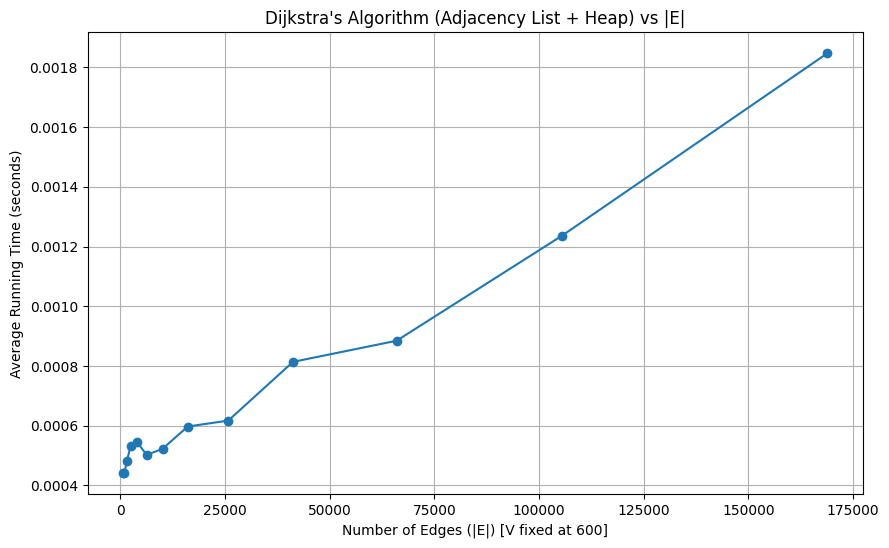

In [56]:
def run_heap_edge_experiment(n=800):
    print(f"Running experiment with varying number of edges (adj list + heap, fixed at {n} vertices)...")
    
    max_edges = n * (n - 1)  # Maximum possible edges for a directed graph
    
    # Generate edge counts
    edge_list = []
    e = n  # Start with n edges (1 per vertex on average)
    while e <= max_edges / 2:  # Test up to half the max edges
        edge_list.append(int(e))
        e *= 1.6  # Double the number of edges each time
    
    n_repetitions = 10
    running_times = []
    edge_counts = []
    
    for m in edge_list:
        _, g2 = make_graph(n, m)  # g2 is the adjacency list
        
        if g2 is None:
            continue
            
        start_time = time.time()
        for _ in range(n_repetitions):
            source = randint(0, n - 1)  # Random source
            d, pi = dijkstra_adj_list_heap(g2, source)
        avg_time = (time.time() - start_time) / n_repetitions
        
        running_times.append(avg_time)
        edge_counts.append(m)
        
        # Print progress
        print(f"Completed {m} edges, average time: {avg_time:.6f} seconds")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(edge_counts, running_times, 'o-')
    plt.xlabel(f'Number of Edges (|E|) [V fixed at {n}]')
    plt.ylabel('Average Running Time (seconds)')
    plt.title('Dijkstra\'s Algorithm (Adjacency List + Heap) vs |E|')
    plt.grid(True)
    plt.savefig('dijkstra_adj_list_heap_edge_experiment.png')
    plt.show()
    
    return edge_counts, running_times

_,_ = run_heap_edge_experiment(600)

## (c) Compare the two implementations in (a) and (b). Discuss which implementation is better and in what circumstances.

One clear-cut circumstance that we can compare is for the sparsity and density of the graphs

In [ ]:
# Will do tomorrow